# Analysing Survey Responses

In [221]:
import pandas as pd
import numpy as np
import re

# Sklearn
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Visual
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [29]:
raw_data = pd.read_excel("data/survey_responses.xlsx", sheet_name="all")
raw_data = raw_data.drop(['Unnamed: 0', 'info:0_help', 'info:1_reason', 'info:2_adhd', 'info:3_stress'], axis=1)

In [30]:
raw_data.head()

,info_injury:0_injury,pain:0_position,synsskarphed:0_Jeg oplever sløret og uklart syn på lang afstand,synsskarphed:1_Jeg oplever sløret og uklart syn på kort afstand,"synsskarphed:2_Jeg oplever, at skarpheden af synet ændrer sig eller varierer i løbet af dagen",synsskarphed:3_Jeg har dårligt nattesyn,synsskarphed:4_Jeg ser ikke godt nok til at køre bil i mørke,synskomfort:0_Jeg får hovedpine eller spændinger efter at have brugt øjnene,synskomfort:1_Jeg bliver svimmel efter at have brugt øjnene,synskomfort:2_Jeg oplever udtrætning / ømhed af øjnene efter at have brugt dem en hel dag,...,rivermead_1_control:6_At være irritabel / bliver nemt vred,rivermead_1_control:7_At føle dig deprimeret eller ked af det,rivermead_2_control:0_At føle dig frustreret eller utålmodig,rivermead_2_control:1_Glemsomhed / dårlig hukommelse,rivermead_2_control:2_Dårlig koncentration,rivermead_2_control:3_At tænke langsommere,rivermead_2_control:4_Sløret syn,"rivermead_2_control:5_Lysfølsomhed, bliver nemt irriteret af skarpt lys",rivermead_2_control:6_At se dobbelt,rivermead_2_control:7_Rastløshed
0,NaN,[],1.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,['5'],4.0,0.0,2.0,4.0,4.0,4.0,0.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,"['0', '1', '2', '4']",0.0,1.0,1.0,0.0,0.0,4.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,['2'],2.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
column_names = ["info:0_help",
"info:1_reason",	
"info:2_adhd",
"info:3_stress",	
"info_injury:0_injury",
"pain:0_position",
"synsskarphed:0_Jeg oplever sløret og uklart syn på lang afstand",
"synsskarphed:1_Jeg oplever sløret og uklart syn på kort afstand",
"synsskarphed:2_Jeg oplever, at skarpheden af synet ændrer sig eller varierer i løbet af dagen",
"synsskarphed:3_Jeg har dårligt nattesyn",
"synsskarphed:4_Jeg ser ikke godt nok til at køre bil i mørke",
"synskomfort:0_Jeg får hovedpine eller spændinger efter at have brugt øjnene",
"synskomfort:1_Jeg bliver svimmel efter at have brugt øjnene",
"synskomfort:2_Jeg oplever udtrætning / ømhed af øjnene efter at have brugt dem en hel dag",
"synskomfort:3_Mine øjne føles tørre og svier",
"synskomfort:4_Jeg har en trang til at gnide i øjnene",
"dobbeltsyn:0_Jeg oplever dobbeltsyn - især ved træthed",
"dobbeltsyn:1_Jeg bliver nødt til at lukke eller dække det ene øje for at se klart",
"dobbeltsyn:2_Jeg oplever, at teksten flyder sammen under læsning",
"lysfolsomhed:0_Jeg oplever at normal belysning indendørs blænder for meget",
"lysfolsomhed:1_Udendørs lys opleves for skarpt – jeg bliver nødt til at bruge solbriller",
"lysfolsomhed:2_Jeg oplever, at lys fra billygter i mørke blænder / er ubehageligt",
"lysfolsomhed:3_Jeg oplever, at belysning med lysstofrør er generende",
"afstand:0_Jeg fejlbedømmer genstandes placering",
"afstand:1_Jeg oplever usikkerhed ved gang / træder forkert / snubler",
"movement:0_Jeg overser objekter i synsfeltet og går ind i ting",
"movement:1_Jeg undgår større forsamlinger / kan ikke klare steder, der ”ser travle ud”",
"movement:2_Jeg generes ved bevægelse i synsfeltet under transport (fx ved tog- eller bilkørsel)",
"movement:3_Jeg distraheres let af bevægelse i synsfeltet, når jeg er koncentreret (fx under samtale eller læsning)",
"movement:4_Jeg oplever utilpashed ved at kigge efter varer under indkøb",
"movement:5_Jeg har udfordringer med at danne mig et overblik i trafikken",
"movement:6_Min balance bliver påvirket, når jeg ser til siden under gang eller cykling",
"movement:7_Jeg oplever kvalme eller svimmel under transport (bil, bus, tog)",
"reading:0_Jeg undgår læsning på papir",
"reading:1_Min koncentrationsevne er påvirket / jeg distraheres nemt ved læsning",
"reading:2_Jeg læser og skriver langsomt / med besvær",
"reading:3_Jeg har svært ved at forstå det læste",
"reading:4_Jeg har svært ved at huske det læste",
"reading:5_Jeg forveksler ord / springer ord over ved læsning",
"reading:6_Jeg mister læsestedet / må bruge fingeren for ikke at miste læsestedet",
"reading:7_Jeg har begrænset udholdenhed ved læsning på papir eller andet nærarbejde (fx håndarbejde eller lignende)",
"screen:0_Jeg undgår læsning på skærm",
"screen:1_Jeg oplever begrænset udholdenhed ved skærmbrug",
"screen:2_Jeg oplever utilpashed ved hurtige bevægelser på skærmen (fx scrolling på computer, hurtige billedskift på tv)",
"screen:3_Jeg har svært ved / generes af at læse undertekster på tv",
"screen:4_Jeg generes af skærmlys (fx computer, mobil eller tv)",
"screen:5_Jeg oplever smerter omkring øjnene ved læsning, skærmbrug eller andet arbejde på tæt hold",
"screen:6_Det tager tid for mig at stille skarpt på objekter længere væk efter at have arbejdet med ting tæt på (fx computer, læsning eller skrivning)",
"rivermead_1:0_Hovedpine",
"rivermead_1:1_Svimmelhed",
"rivermead_1:2_Kvalme og/eller opkastning",
"rivermead_1:3_Lydfølsomhed / bliver nemt irriteret af høje lyde",
"rivermead_1:4_Søvnproblemer",
"rivermead_1:5_Træthed",
"rivermead_1:6_At være irritabel / bliver nemt vred",
"rivermead_1:7_At føle dig deprimeret eller ked af det",
"rivermead_2:0_At føle dig frustreret eller utålmodig",
"rivermead_2:1_Glemsomhed / dårlig hukommelse",
"rivermead_2:2_Dårlig koncentration",
"rivermead_2:3_At tænke langsommere",
"rivermead_2:4_Sløret syn",
"rivermead_2:5_Lysfølsomhed, bliver nemt irriteret af skarpt lys",
"rivermead_2:6_At se dobbelt",
"rivermead_2:7_Rastløshed"	
"category",
"date",
"id",
"version",
"synsskarphed:2_Jeg oplever, at skarpheden af synet varierer i løbet af dagen",
"synsskarphed:5_Hvor ofte oplevede du ovenstående symptomer, før du fik en hjernerystelse?",
"synskomfort:2_Jeg oplever udtrætning eller ømhed af øjnene efter at have brugt dem en hel dag",
"synskomfort:5_Hvor ofte oplevede du ovenstående symptomer, før du fik en hjernerystelse?",
"dobbeltsyn:3_Hvor ofte oplevede du ovenstående symptomer, før du fik en hjernerystelse?",
"lysfolsomhed:1_Udendørs lys blænder – jeg bliver nødt til at bruge solbriller",
"lysfolsomhed:2_Jeg oplever, at lys fra billygter i mørke blænder eller er ubehageligt",
"lysfolsomhed:4_Hvor ofte oplevede du ovenstående symptomer, før du fik en hjernerystelse?",
"afstand:2_Hvor ofte oplevede du ovenstående symptomer, før du fik en hjernerystelse?",
"movement:1_Jeg undgår situationer med mange synsindtryk",
"movement:6_Min balance bliver påvirket, når jeg ser til siden under gang eller når jeg cykler",
"movement:8_Hvor ofte oplevede du ovenstående symptomer, før du fik en hjernerystelse?",
"reading:1_Min koncentrationsevne er påvirket ved læsning",
"reading:6_Jeg mister læsestedet ved læsning",
"reading:7_Jeg har begrænset udholdenhed ved synskrævende aktiviteter tæt på",
"reading:8_Hvor ofte oplevede du ovenstående symptomer, før du fik en hjernerystelse?",
"screen:3_Jeg har svært ved at læse undertekster på tv",
"screen:7_Hvor ofte oplevede du ovenstående symptomer, før du fik en hjernerystelse?",
"rivermead_1_control:0_Hovedpine",
"rivermead_1_control:1_Svimmelhed",
"rivermead_1_control:2_Kvalme og/eller opkastning",
"rivermead_1_control:3_Lydfølsomhed / bliver nemt irriteret af høje lyde",
"rivermead_1_control:4_Søvnproblemer",
"rivermead_1_control:5_Træthed",
"rivermead_1_control:6_At være irritabel / bliver nemt vred",
"rivermead_1_control:7_At føle dig deprimeret eller ked af det",
"rivermead_2_control:0_At føle dig frustreret eller utålmodig",
"rivermead_2_control:1_Glemsomhed / dårlig hukommelse",
"rivermead_2_control:2_Dårlig koncentration",
"rivermead_2_control:3_At tænke langsommere",
"rivermead_2_control:4_Sløret syn",
"rivermead_2_control:5_Lysfølsomhed, bliver nemt irriteret af skarpt lys",
"rivermead_2_control:6_At se dobbelt",
"rivermead_2_control:7_Rastløshed"]

### Combine columns with same question using coelasce

In [32]:
data_coalesce = raw_data
data_coalesce["synsskarphed:2_Jeg oplever, at skarpheden af synet ændrer sig eller varierer i løbet af dagen"] = (
    data_coalesce[["synsskarphed:2_Jeg oplever, at skarpheden af synet ændrer sig eller varierer i løbet af dagen", 
        "synsskarphed:2_Jeg oplever, at skarpheden af synet varierer i løbet af dagen"]]
    .bfill(axis=1).iloc[:, 0]
)
data_coalesce["synskomfort:2_Jeg oplever udtrætning / ømhed af øjnene efter at have brugt dem en hel dag"] = (
    data_coalesce[["synskomfort:2_Jeg oplever udtrætning / ømhed af øjnene efter at have brugt dem en hel dag", 
        "synskomfort:2_Jeg oplever udtrætning eller ømhed af øjnene efter at have brugt dem en hel dag"]]
    .bfill(axis=1).iloc[:, 0]
)
data_coalesce["lysfolsomhed:1_Udendørs lys opleves for skarpt – jeg bliver nødt til at bruge solbriller"] = (
    data_coalesce[["lysfolsomhed:1_Udendørs lys opleves for skarpt – jeg bliver nødt til at bruge solbriller", 
        "lysfolsomhed:1_Udendørs lys blænder – jeg bliver nødt til at bruge solbriller"]]
    .bfill(axis=1).iloc[:, 0]
)
data_coalesce["lysfolsomhed:2_Jeg oplever, at lys fra billygter i mørke blænder / er ubehageligt"] = (
    data_coalesce[["lysfolsomhed:2_Jeg oplever, at lys fra billygter i mørke blænder / er ubehageligt", 
        "lysfolsomhed:2_Jeg oplever, at lys fra billygter i mørke blænder eller er ubehageligt"]]
    .bfill(axis=1).iloc[:, 0]
)
data_coalesce["movement:1_Jeg undgår større forsamlinger / kan ikke klare steder, der ”ser travle ud”"] = (
    data_coalesce[["movement:1_Jeg undgår større forsamlinger / kan ikke klare steder, der ”ser travle ud”", 
        "movement:1_Jeg undgår situationer med mange synsindtryk"]]
    .bfill(axis=1).iloc[:, 0]
)
data_coalesce["movement:6_Min balance bliver påvirket, når jeg ser til siden under gang eller cykling"] = (
    data_coalesce[["movement:6_Min balance bliver påvirket, når jeg ser til siden under gang eller cykling", 
        "movement:6_Min balance bliver påvirket, når jeg ser til siden under gang eller når jeg cykler"]]
    .bfill(axis=1).iloc[:, 0]
)
data_coalesce["reading:1_Min koncentrationsevne er påvirket / jeg distraheres nemt ved læsning"] = (
    data_coalesce[["reading:1_Min koncentrationsevne er påvirket / jeg distraheres nemt ved læsning", 
        "reading:1_Min koncentrationsevne er påvirket ved læsning"]]
    .bfill(axis=1).iloc[:, 0]
)
data_coalesce["reading:6_Jeg mister læsestedet / må bruge fingeren for ikke at miste læsestedet"] = (
    data_coalesce[["reading:6_Jeg mister læsestedet / må bruge fingeren for ikke at miste læsestedet", 
        "reading:6_Jeg mister læsestedet ved læsning"]]
    .bfill(axis=1).iloc[:, 0]
)
data_coalesce["reading:7_Jeg har begrænset udholdenhed ved læsning på papir eller andet nærarbejde (fx håndarbejde eller lignende)"] = (
    data_coalesce[["reading:7_Jeg har begrænset udholdenhed ved læsning på papir eller andet nærarbejde (fx håndarbejde eller lignende)", 
        "reading:7_Jeg har begrænset udholdenhed ved synskrævende aktiviteter tæt på"]]
    .bfill(axis=1).iloc[:, 0]
)
data_coalesce["screen:3_Jeg har svært ved / generes af at læse undertekster på tv"] = (
    data_coalesce[["screen:3_Jeg har svært ved / generes af at læse undertekster på tv", 
        "screen:3_Jeg har svært ved at læse undertekster på tv"]]
    .bfill(axis=1).iloc[:, 0]
)

data_coalesce = data_coalesce.drop([
    "synsskarphed:2_Jeg oplever, at skarpheden af synet varierer i løbet af dagen",
    "synskomfort:2_Jeg oplever udtrætning eller ømhed af øjnene efter at have brugt dem en hel dag",
    "lysfolsomhed:1_Udendørs lys blænder – jeg bliver nødt til at bruge solbriller",
    "lysfolsomhed:2_Jeg oplever, at lys fra billygter i mørke blænder eller er ubehageligt",
    "movement:1_Jeg undgår situationer med mange synsindtryk",
    "movement:6_Min balance bliver påvirket, når jeg ser til siden under gang eller når jeg cykler",
    "reading:1_Min koncentrationsevne er påvirket ved læsning",
    "reading:6_Jeg mister læsestedet ved læsning",
    "reading:7_Jeg har begrænset udholdenhed ved synskrævende aktiviteter tæt på",
    "screen:3_Jeg har svært ved at læse undertekster på tv"
    ], axis=1)


### Split data in meta data and question

In [33]:
metadata = data_coalesce.filter(["category", "date", "id", "version"])
data = data_coalesce.drop(["category", "date", "id", "version"], axis=1)

### Rename columns

In [34]:
column_dict = { c:("").join(re.split(r"(:[0-9])_", c)[0:2]) for c in data.columns}
data.columns = column_dict.values()

In [35]:
data.head()

,info_injury:0,pain:0,synsskarphed:0,synsskarphed:1,synsskarphed:2,synsskarphed:3,synsskarphed:4,synskomfort:0,synskomfort:1,synskomfort:2,...,rivermead_1_control:6,rivermead_1_control:7,rivermead_2_control:0,rivermead_2_control:1,rivermead_2_control:2,rivermead_2_control:3,rivermead_2_control:4,rivermead_2_control:5,rivermead_2_control:6,rivermead_2_control:7
0,NaN,[],1.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,['5'],4.0,0.0,2.0,4.0,4.0,4.0,0.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,"['0', '1', '2', '4']",0.0,1.0,1.0,0.0,0.0,4.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,['2'],2.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Use coalesce to combine answers from patient and control group

In [37]:
data['rivermead_1:0'] = data[['rivermead_1:0', 'rivermead_1_control:0']].bfill(axis=1).iloc[:, 0]
data['rivermead_1:1'] = data[['rivermead_1:1', 'rivermead_1_control:1']].bfill(axis=1).iloc[:, 0]
data['rivermead_1:2'] = data[['rivermead_1:2', 'rivermead_1_control:2']].bfill(axis=1).iloc[:, 0]
data['rivermead_1:3'] = data[['rivermead_1:3', 'rivermead_1_control:3']].bfill(axis=1).iloc[:, 0]
data['rivermead_1:4'] = data[['rivermead_1:4', 'rivermead_1_control:4']].bfill(axis=1).iloc[:, 0]
data['rivermead_1:5'] = data[['rivermead_1:5', 'rivermead_1_control:5']].bfill(axis=1).iloc[:, 0]
data['rivermead_1:6'] = data[['rivermead_1:6', 'rivermead_1_control:6']].bfill(axis=1).iloc[:, 0]
data['rivermead_1:7'] = data[['rivermead_1:7', 'rivermead_1_control:7']].bfill(axis=1).iloc[:, 0]
data['rivermead_2:0'] = data[['rivermead_2:0', 'rivermead_2_control:0']].bfill(axis=1).iloc[:, 0]
data['rivermead_2:1'] = data[['rivermead_2:1', 'rivermead_2_control:1']].bfill(axis=1).iloc[:, 0]
data['rivermead_2:2'] = data[['rivermead_2:2', 'rivermead_2_control:2']].bfill(axis=1).iloc[:, 0]
data['rivermead_2:3'] = data[['rivermead_2:3', 'rivermead_2_control:3']].bfill(axis=1).iloc[:, 0]
data['rivermead_2:4'] = data[['rivermead_2:4', 'rivermead_2_control:4']].bfill(axis=1).iloc[:, 0]
data['rivermead_2:5'] = data[['rivermead_2:5', 'rivermead_2_control:5']].bfill(axis=1).iloc[:, 0]
data['rivermead_2:6'] = data[['rivermead_2:6', 'rivermead_2_control:6']].bfill(axis=1).iloc[:, 0]
data['rivermead_2:7'] = data[['rivermead_2:7', 'rivermead_2_control:7']].bfill(axis=1).iloc[:, 0]

data = data.drop([
    'rivermead_1_control:0', 
    'rivermead_1_control:1', 
    'rivermead_1_control:2',
    'rivermead_1_control:3',
    'rivermead_1_control:4',
    'rivermead_1_control:5',
    'rivermead_1_control:6',
    'rivermead_1_control:7',
    'rivermead_2_control:0',
    'rivermead_2_control:1',
    'rivermead_2_control:2',
    'rivermead_2_control:3',
    'rivermead_2_control:4',
    'rivermead_2_control:5',
    'rivermead_2_control:6',
    'rivermead_2_control:7'
], axis=1)

### Define topic dict

In [ ]:
# # List of topics
# topics = list( set( re.split("[:]", s)[0] for s in data.columns))

# # Assign columns to topics
# topic_dict = {t:[] for t in topics}
# for i in data.columns:
#     for t in topics:
#         if t in i:
#             topic_dict[t].append(i)
            
# # Problem with info

### Recombine data

In [93]:
data_full = pd.concat([data, metadata], axis=1)

In [108]:
data_full.to_excel("test.xlsx")

### Remove duplicate participants

In [96]:
# Sort by ID and Date to ensure the latest response is last
data_sorted = data_full.sort_values(by=["id", "date"], ascending=[True, False])

# Keep only the latest row per participant
data_rm_dups = data_sorted.drop_duplicates(subset="id", keep="first")

# Reset index
data_rm_dups.reset_index(drop=True, inplace=True)

In [97]:
# Removed half of the rows
(data_full.shape[0]-data_rm_dups.shape[0])/data_full.shape[0]

0.49038461538461536

### Remove null values

#### Remove null columns

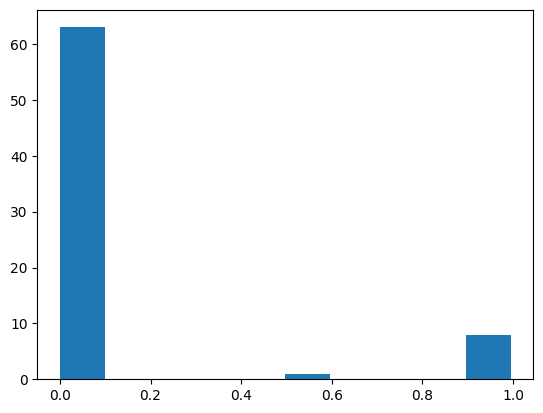

In [98]:
col_nan_count = data_rm_dups.isna().sum(axis=0)
plt.hist(col_nan_count/data_rm_dups.shape[0]);

In [99]:
# Remove columns with questions answered by less than 40 % of the participants
# The column info_injury:0 were only answered by around 50 % of the 
m = col_nan_count <= round(data_rm_dups.shape[0]*0.60)
data_rm_cols = data_rm_dups.loc[:,m]

In [100]:
# Columns removed
data_full.shape[1]-data_rm_cols.shape[1]

8

In [101]:
set(data_full.columns) - set(data_rm_cols.columns)

{'afstand:2',
 'dobbeltsyn:3',
 'lysfolsomhed:4',
 'movement:8',
 'reading:8',
 'screen:7',
 'synskomfort:5',
 'synsskarphed:5'}

#### Remove null rows

In [102]:
row_nan_count = data_rm_cols.isna().sum(axis=1)

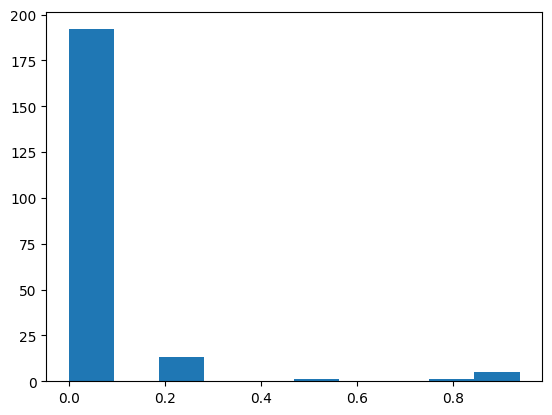

In [103]:
plt.hist(row_nan_count/data_rm_cols.shape[1]);

In [147]:
# Remove rows with participant that have answered less than 60 % of the questions
m = row_nan_count <= round(data_rm_cols.shape[1]*0.10)
data_rm_cols_rows = data_rm_cols[m]

In [148]:
data_rm_cols.shape[0]-data_rm_cols_rows.shape[0]

20

In [149]:
set(data_rm_cols["id"])-set(data_rm_cols_rows["id"])

{91,
 96,
 109,
 111,
 113,
 121,
 125,
 129,
 134,
 135,
 139,
 144,
 147,
 149,
 150,
 161,
 196,
 279,
 295,
 399}

In [151]:
data_rm_cols_rows.to_excel("test.xlsx")

### Transform to binary columns

In [152]:
# Category
category_dict = {"CONTROL" : 0, "PATIENT" : 1}
data_rm_cols_rows.loc[:,'category'] = data_rm_cols_rows.loc[:,'category'].map(category_dict)

In [154]:
import ast

pain = data_rm_cols_rows['pain:0']
data_rm_rows_cols = data_rm_cols_rows.drop("pain:0", axis=1)
pain = pain.apply(ast.literal_eval).apply(lambda x: '|'.join(x)).str.get_dummies()
pain.columns = [f"pain:{v}" for v in pain.columns]

pain = pain.drop("pain:6", axis=1)

In [155]:
data_encoded = pd.concat([data_rm_rows_cols, pain], axis=1)

### Save cleaned data

In [156]:
data_clean = data_encoded

In [157]:
data_clean.to_excel("test.xlsx")

### Split data

In [190]:
X = data_clean.drop(["category", "date", "id", "version"], axis=1)
y = data_clean["category"].astype("int")
metadata = data_clean.loc[:,["date", "id", "version"]]

## Analysis

In [295]:
# List of topics
topics = list( set( re.split("[:]", s)[0] for s in X.columns))

# Assign columns to topics
topic_dict = {t:[] for t in topics}
for i in X.columns:
    for t in topics:
        if t in i:
            topic_dict[t].append(i)
            
# Problem with info

In [297]:
topic_areas = [
    #topic_dict["info_injury"] 
    topic_dict["movement"] 
        + topic_dict["synsskarphed"] 
        + topic_dict["afstand"] 
        + topic_dict["screen"] 
        + topic_dict["pain"] 
        + topic_dict["lysfolsomhed"] 
        + topic_dict["reading"] 
        + topic_dict["dobbeltsyn"]
        + topic_dict["synskomfort"]
        + topic_dict["rivermead_1"]
        + topic_dict["rivermead_2"],
    topic_dict["rivermead_1"]
        + topic_dict["rivermead_2"],
    topic_dict["synsskarphed"] 
        + topic_dict["movement"] 
        + topic_dict["afstand"] 
        + topic_dict["screen"] 
        + topic_dict["lysfolsomhed"] 
        + topic_dict["reading"] 
        + topic_dict["dobbeltsyn"] 
        + topic_dict["synskomfort"],
    topic_dict["pain"]]

In [298]:
topic_areas

[['movement:0',
  'movement:1',
  'movement:2',
  'movement:3',
  'movement:4',
  'movement:5',
  'movement:6',
  'movement:7',
  'synsskarphed:0',
  'synsskarphed:1',
  'synsskarphed:2',
  'synsskarphed:3',
  'synsskarphed:4',
  'afstand:0',
  'afstand:1',
  'screen:0',
  'screen:1',
  'screen:2',
  'screen:3',
  'screen:4',
  'screen:5',
  'screen:6',
  'pain:0',
  'pain:1',
  'pain:2',
  'pain:3',
  'pain:4',
  'pain:5',
  'lysfolsomhed:0',
  'lysfolsomhed:1',
  'lysfolsomhed:2',
  'lysfolsomhed:3',
  'reading:0',
  'reading:1',
  'reading:2',
  'reading:3',
  'reading:4',
  'reading:5',
  'reading:6',
  'reading:7',
  'dobbeltsyn:0',
  'dobbeltsyn:1',
  'dobbeltsyn:2',
  'synskomfort:0',
  'synskomfort:1',
  'synskomfort:2',
  'synskomfort:3',
  'synskomfort:4',
  'rivermead_1:0',
  'rivermead_1:1',
  'rivermead_1:2',
  'rivermead_1:3',
  'rivermead_1:4',
  'rivermead_1:5',
  'rivermead_1:6',
  'rivermead_1:7',
  'rivermead_2:0',
  'rivermead_2:1',
  'rivermead_2:2',
  'rivermead_2

### PCA Analysis

Inspiration: https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html#sphx-glr-auto-examples-decomposition-plot-pca-iris-py

In [299]:
pca = PCA(n_components=2)

# X_transformed = pca.fit(X).transform(X)
# pca.explained_variance_ratio_

IndexError: list index out of range

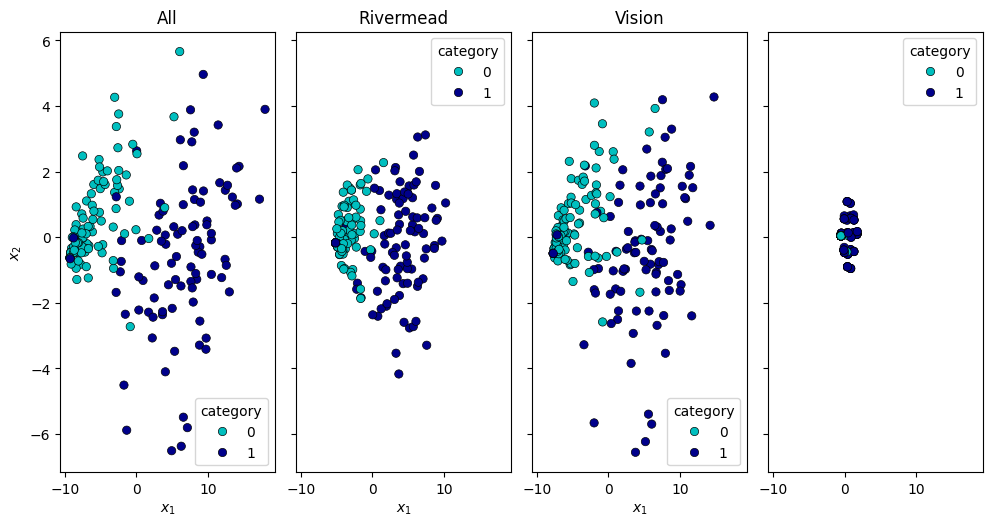

In [300]:
# Define plot 
fig, axs = plt.subplots(1, len(topic_areas[0:4]), figsize=(10, 5), sharex=True, sharey=True)
plt.tight_layout();
fig.subplots_adjust(wspace=0.1, hspace=.2);

# Define color schemes
# cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
# cmap_bold = ['darkorange', 'c', 'darkblue']
cmap_bold = ['c', 'darkblue']

# Define titles
titles = ["All", "Rivermead", "Vision"]

for i in range(len(topic_areas[0:4])):
    X_subset = X.filter(topic_areas[i])
    X_transformed = pca.fit(X_subset).transform(X_subset)
    
    # Get ax
    ax = axs[i]

    # Plot also the training points
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=y, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
    
    ax.set_title(titles[i]);

    ax.set_xlabel("$x_1$");
    ax.set_ylabel("$x_2$");

# plt.title("PCA")
plt.show()

### LDA

Inpiration: https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py

In [197]:
lda = LinearDiscriminantAnalysis(n_components=1)

IndexError: list index out of range

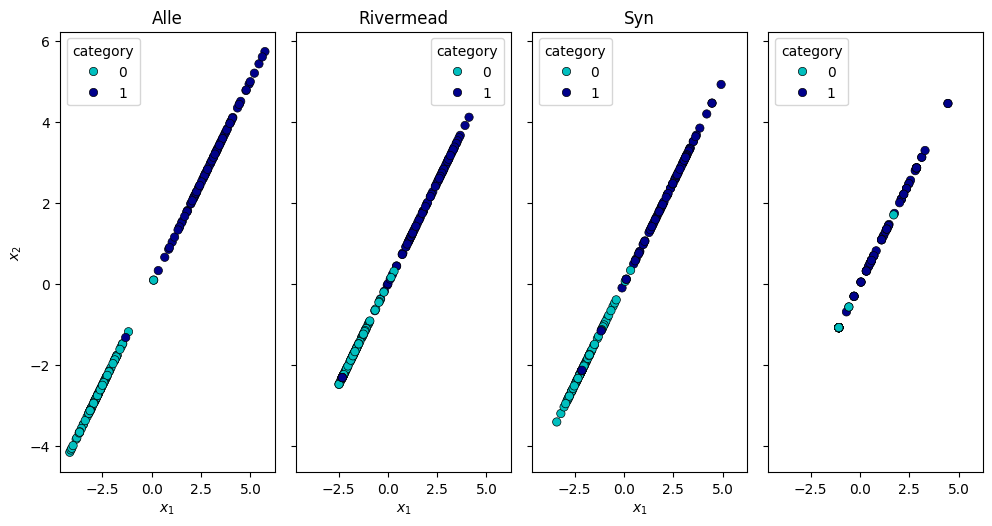

In [302]:
# Define plot 
fig, axs = plt.subplots(1, len(topic_areas[0:4]), figsize=(10, 5), sharex=True, sharey=True)
plt.tight_layout();
fig.subplots_adjust(wspace=0.1, hspace=.2);

# Define color schemes
cmap_bold = ['c', 'darkblue']

# Define titles
titles = ["Alle", "Rivermead", "Syn"]

for i in range(len(topic_areas[0:4])):
    X_subset = X.filter(topic_areas[i])
    X_transformed = lda.fit(X_subset, y).transform(X_subset)
    
    # Get ax
    ax = axs[i]

    # Plot also the training points
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 0], hue=y, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
    
    ax.set_title(titles[i]);

    ax.set_xlabel("$x_1$");
    ax.set_ylabel("$x_2$");

# plt.title("LDA")
plt.show()

In [206]:
lda.coef_[0]

array([ 0.32795371, -0.38876898,  0.99306383, -0.57566005,  0.29581041,
        2.26738452,  2.31592151,  0.11046076, -0.83440753,  0.45794066,
       -0.57624921, -0.15863054, -0.68808023, -1.58297404,  0.97023128,
        0.94894894,  1.64511369,  0.0753708 ,  1.58074381,  0.29626845,
       -0.07254659, -1.45714209,  0.19693113,  0.06364664, -0.6149991 ,
       -0.35733605, -0.4875794 ,  1.46038585,  0.07992251, -1.82340916,
        0.81715028,  0.08219565, -0.59169328,  1.69864239, -0.55084953,
        0.05676632,  0.01462234,  0.73881502,  0.91670811, -0.46217116,
        0.3385093 , -0.9660873 ])

In [202]:
len(topic_areas[2])

50

### Gaussian Mixture Clustering

Inpiration: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py

In [308]:
# Dicts to save WCSS and BCSS
within_cluster_variance = {"n_clusters" : [], "Within cluster ss" : []}
between_cluster_variance = {"n_clusters" : [], "Between cluster ss" : []}
cluster_balance = {"n_clusters" : [], "Cluster balance" : []}
silhouette_scores = {"n_clusters" : [], "Silhouette score" : []}
cluster_purity = {"n_clusters" : [], "Cluster purity" : []}

pca = PCA(n_components=2)

n_splits=2
skf = StratifiedKFold(n_splits=n_splits)

y_subset = y[y==1]
X_subset = X[y==1].filter(topic_areas[2]) # .drop("info_injury:0",axis=1)

for n_clusters in range(4,11):
    wcss_test = []
    bcss_test = []
    sil_test = []
    cps_test = []

    for train_index, test_index in skf.split(X_subset, y_subset):
        X_train = X_subset.iloc[train_index]
        X_test = X_subset.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        model = GaussianMixture(n_components=n_clusters, covariance_type='full', reg_covar=1e-3, init_params='k-means++', random_state=42)
        model.fit(X_train)

        # Predict labels
        labels_train = model.predict(X_train)
        labels_test = model.predict(X_test)

        # Compute WCSS on Test Data
        wcss = np.sum([
            np.mean(np.linalg.norm(X_test[labels_test == k] - model.means_[k], axis=1) ** 2)
            for k in range(model.n_components) if np.any(labels_test == k)
        ])

        # Compute Global Mean for Test Data
        global_mean_test = np.mean(X_test, axis=0)

        # Compute BCSS on Test Data
        bcss = np.sum([
            len(X_test[labels_test == k]) * np.linalg.norm(model.means_[k] - global_mean_test) ** 2
            for k in range(model.n_components) if np.any(labels_test==k)
        ])

        # Compute silhouette score
        sil = silhouette_score(X_test, labels_test)

        # Compute Purity Score (how well clusters match patient/control labels)
        contingency_matrix = np.zeros((n_clusters, 2))  # Assuming two classes (patients & controls)
        for k in range(n_clusters):
            if np.any(labels_test == k):
                contingency_matrix[k, 0] = np.sum((labels_test == k) & (y_test == 0))  # Controls
                contingency_matrix[k, 1] = np.sum((labels_test == k) & (y_test == 1))  # Patients
        cps = np.sum(np.max(contingency_matrix, axis=1)) / np.sum(contingency_matrix)

        # Save wcss and bcss temporarity
        wcss_test.append(wcss)
        bcss_test.append(bcss)
        sil_test.append(sil)
        cps_test.append(cps)

    # Save scores
    wcss_avg = np.mean(wcss_test)
    bcss_avg = np.mean(bcss_test)
    sil_avg = np.mean(sil_test)
    cps_avg = np.mean(cps_test)

    within_cluster_variance["n_clusters"].append(n_clusters)
    within_cluster_variance["Within cluster ss"].append(wcss_avg)

    between_cluster_variance["n_clusters"].append(n_clusters)
    between_cluster_variance["Between cluster ss"].append(bcss_avg)

    cluster_balance["n_clusters"].append(n_clusters)
    cluster_balance["Cluster balance"].append((bcss_avg-wcss_avg)/(bcss_avg+wcss_avg))

    silhouette_scores["n_clusters"].append(n_clusters)
    silhouette_scores["Silhouette score"].append(sil_avg)

    cluster_purity["n_clusters"].append(n_clusters)
    cluster_purity["Cluster purity"].append(cps_avg)

#### Optimal number of clusters

<Axes: xlabel='n_clusters', ylabel='Silhouette score'>

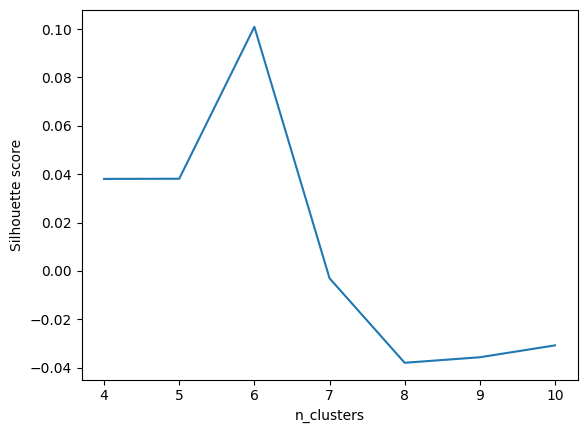

In [309]:
within_cluster_variance_df = pd.DataFrame.from_dict(within_cluster_variance)
between_cluster_variance_df = pd.DataFrame.from_dict(between_cluster_variance)
cluster_balance_index_df = pd.DataFrame.from_dict(cluster_balance)
silhouette_score_df = pd.DataFrame.from_dict(silhouette_scores)

# plot_data = within_cluster_variance_df.set_index("n_clusters") \
#     .join(between_cluster_variance_df.set_index("n_clusters")) \
#     .join(cluster_balance_index_df).set_index("n_clusters") \
#     .join(silhouette_score_df).set_index("n_clusters")

sns.lineplot(data = silhouette_score_df, x="n_clusters", y="Silhouette score")

#### Plot result of clustering

<Axes: >

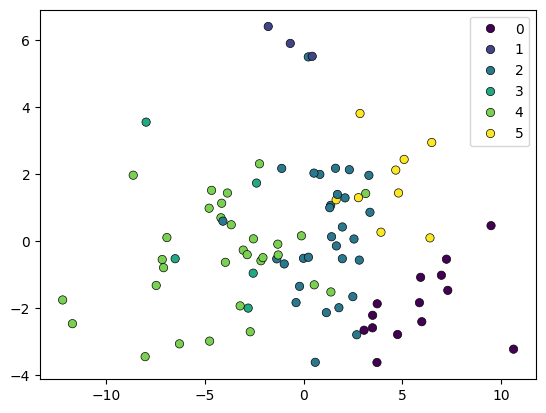

In [310]:
n_cluster_optimal = 6

# Gaussian mixture
gmm = GaussianMixture(n_components=n_cluster_optimal, covariance_type='full', init_params='k-means++', random_state=42)
gmm.fit(X_subset)
labels = gmm.predict(X_subset)

# PCA
pca = PCA(n_components=2)
X_transformed = pca.fit(X_subset).transform(X_subset)

# Plot cluster data
sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette='viridis', alpha=1.0, edgecolor="black")

### Hierarchical clustering

In [282]:
# Dicts to save WCSS and BCSS
silhouette_scores = {"n_clusters" : [], "Silhouette score" : []}
cluster_purity = {"n_clusters" : [], "Cluster purity" : []}

pca = PCA(n_components=2)

n_splits=5
skf = StratifiedKFold(n_splits=n_splits)

y_subset = y[y==1]
X_subset = X[y==1].filter(topic_areas[1]) # .drop("info_injury:0",axis=1)

for n_clusters in range(2,11):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    model.fit(X_subset)

    # Compute silhouette score
    sil_score = silhouette_score(X_subset, model.labels_)

    # Compute Purity Score (how well clusters match patient/control labels)
    contingency_matrix = np.zeros((n_clusters, 2))  # Assuming two classes (patients & controls)
    for k in range(n_clusters):
        if np.any(model.labels_ == k):
            contingency_matrix[k, 0] = np.sum((model.labels_ == k) & (y_subset == 0))  # Controls
            contingency_matrix[k, 1] = np.sum((model.labels_ == k) & (y_subset == 1))  # Patients
    cps_score = np.sum(np.max(contingency_matrix, axis=1)) / np.sum(contingency_matrix)

    silhouette_scores["n_clusters"].append(n_clusters)
    silhouette_scores["Silhouette score"].append(sil_score)

    cluster_purity["n_clusters"].append(n_clusters)
    cluster_purity["Cluster purity"].append(cps_score)

#### Optimal number of clusters

<Axes: xlabel='n_clusters', ylabel='Silhouette score'>

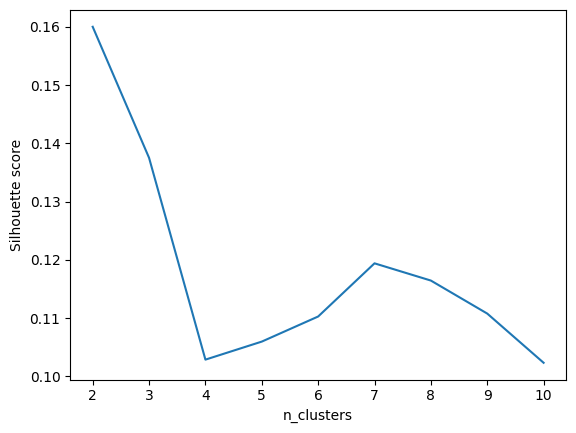

In [283]:
silhouette_score_df = pd.DataFrame.from_dict(silhouette_scores)

sns.lineplot(data = silhouette_score_df, x="n_clusters", y="Silhouette score")

#### Plot result of clustering

<Axes: >

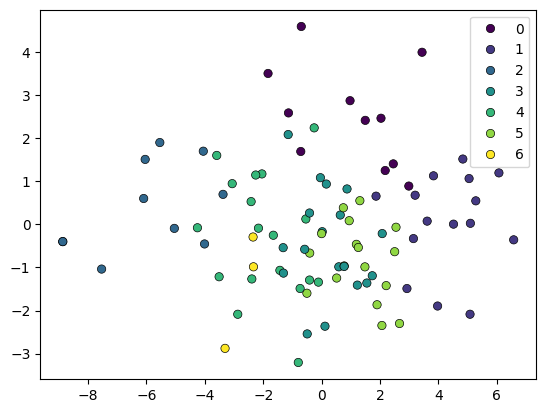

In [285]:
n_cluster_optimal = 7

# Gaussian mixture
agg = AgglomerativeClustering(n_clusters=n_cluster_optimal, linkage="ward")
agg.fit(X_subset)
labels = agg.labels_

# PCA
pca = PCA(n_components=2)
X_transformed = pca.fit(X_subset).transform(X_subset)

# Plot cluster data
sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette='viridis', alpha=1.0, edgecolor="black")